In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
import json
import requests
import time
import datetime as dt
from datetime import date, timedelta, datetime

from itertools import repeat
import itertools

import numpy as np
import pandas as pd
import statistics as st
import scipy.stats as ss
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [18]:
class FetchPrepareData():
    def __init__(self):
        self.dfdict = {}
        self.dfdict['train'] = self.get_train_data()
        self.dfdict['test'] = self.get_test_data()
        self.dfdict['sample'] = self.get_sample_data()
        self.dfdict['store'] = self.get_store_data()
        
    def get_train_data(self,name='train'):
        filename = f'data/{name}.csv'        
        return pd.read_csv(filename)
    
    def get_test_data(self,name='test'):
        filename = f'data/{name}.csv'        
        return pd.read_csv(filename)
        
    def get_store_data(self,name='store'):
        filename = f'data/{name}.csv'        
        return pd.read_csv(filename)  
    
    def get_sample_data(self,name='sample_submission'):
        filename = f'data/{name}.csv'        
        return pd.read_csv(filename)  
        
    def df_to_prophet(self,name='train', 
                timecol="Date",
                targetcol="Sales",
                ftransform=None, 
                prefilter={}, 
                postfilter={},
                rs = '1D'):
        '''
        prepare data frame to prophet modelling
            dfin - input data frame
            timecol - the column name for time/date
            prefilter - a dictionary that contains column_name:value
            postfilter - a dictionary that contains column_name:value
            ftransform - a function to apply after prefiltering takes dfin as input
            rs - unit of time to resample time column 
        '''
        if name in ['train','test','sample']:
            df = self.dfdict[name].copy()
        else:
            print("only name=['train','test','sample'] are allowed")
            return pd.DataFrame()
        
        df['ts'] =  pd.to_datetime(df[timecol]).dt.tz_localize(None)
        df['ts'] = df['ts'].dt.to_pydatetime()

        #apply pre-filter
        for k, v in prefilter.items():
            print(f'Applying pre transform filter with column={k}, value={v}')
            df = df[df[k]==v]

        #transform
        if ftransform is not None:
            print(f'Applying functional transformation ..')
            df = ftransform(df)

        #apply post filter
        for k, v in prefilter.items():
            print(f'Applying post transform filter with column={k}, value={v}')
            df = df[df[k]==v]

        df = df.reset_index().set_index('ts').resample(rs).sum() 
        df = df.reset_index()

        df = df[['ts', targetcol]]
        df = df.rename(columns={"ts": "ds", targetcol: "y"})
        df = df.dropna()
        df.ds = pd.Series([v.to_pydatetime() for v in df.ds], dtype=object)
        return df

def plot_prophet(tsdf, 
                 changepoint_prior_scale=0.001, 
                 seasonality_prior_scale=1.0, 
                 periods=10, 
                 split=0.8 ):
    
    model = (Prophet(changepoint_prior_scale=changepoint_prior_scale, 
                    seasonality_prior_scale=seasonality_prior_scale, 
                    interval_width=0.95, 
                    daily_seasonality=True, 
                    weekly_seasonality=True, 
                    yearly_seasonality=False) \
            .add_seasonality(name='monthly', period=30.5, fourier_order=5) \
            .fit(tsdf)
            )
    
    future = model.make_future_dataframe(periods)
    forecast = model.predict(future)
    components = model.plot_components(forecast)

    forecast.ds = pd.Series([v.to_pydatetime() for v in forecast.ds], dtype=object)

    split = 0.8
    threshold_date_train = tsdf.ds[ int(len(tsdf.ds)*split) ]
    threshold_date_forecast = forecast.ds[ int(len(forecast.ds)*split) ]

    forecast_train = forecast[ threshold_date_forecast >= forecast.ds ]
    forecast_test = forecast[ threshold_date_forecast < forecast.ds ]
    df_train = tsdf[ threshold_date_train >= tsdf.ds ]
    df_test = tsdf[ threshold_date_train < tsdf.ds ]

    fig, ax = plt.subplots(figsize=(20,10))
    sns.set_style('darkgrid', {'axes.facecolor': '.9'})
    sns.set_palette(palette='deep')
    sns_c = sns.color_palette(palette='deep')

    ax.fill_between( x=forecast['ds'], y1=forecast['yhat_lower'], y2=forecast['yhat_upper'],
        color=sns_c[2], alpha=0.25, label=r'0.95 credible_interval')

    sns.scatterplot(x='ds', y='y', label='real historic data', data=df_train, ax=ax, color='black')
    sns.scatterplot(x='ds', y='y', label='real test data', data=df_test, ax=ax, color = 'red')
    sns.lineplot(x='ds', y='yhat', label='historic fit', data=forecast_train, ax=ax, color = 'blue')
    sns.lineplot(x='ds', y='yhat', label='future prediction', data=forecast_test, ax=ax, color = 'orange')
    ax.axvline(threshold_date_train, color=sns_c[3], linestyle='--', label='80% train-test data split')
    ax.legend(loc='upper left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Engagement rate')
    ax.tick_params(axis='x', rotation=45)
    ax.set(title='Engagement rate model fit & prediction for Campaign ID ')
    
    return fig, components
    
    
#     model = Prophet(mcmc_samples=1000).fit(tsdf)
    
#     model = Prophet(seasonality_mode='multiplicative').add_seasonality('quarterly', period=91.25, fourier_order=8, 
#                        mode='additive').add_regressor('regressor', mode='additive').fit(tsdf)
    
#     model = Prophet(seasonality_mode='multiplicative').add_seasonality(name='monthly', period=30.5, fourier_order=5
#             ).add_seasonality(name='weekly', period=7, fourier_order=3
#             ).add_seasonality(name='daily', period=1, fourier_order=1
#             ).fit(tsdf)

In [19]:
rom.dfdict['train'].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [20]:
rom = FetchPrepareData()
tsdf = rom.df_to_prophet(name='train',prefilter={'Store':1})
print(tsdf.shape)
tsdf.head()

/workspace/.conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Applying pre transform filter with column=Store, value=1
Applying post transform filter with column=Store, value=1
(942, 2)


,ds,y
0,2013-01-01 00:00:00,0
1,2013-01-02 00:00:00,5530
2,2013-01-03 00:00:00,4327
3,2013-01-04 00:00:00,4486
4,2013-01-05 00:00:00,4997


(<Figure size 1440x720 with 1 Axes>, <Figure size 648x864 with 4 Axes>)

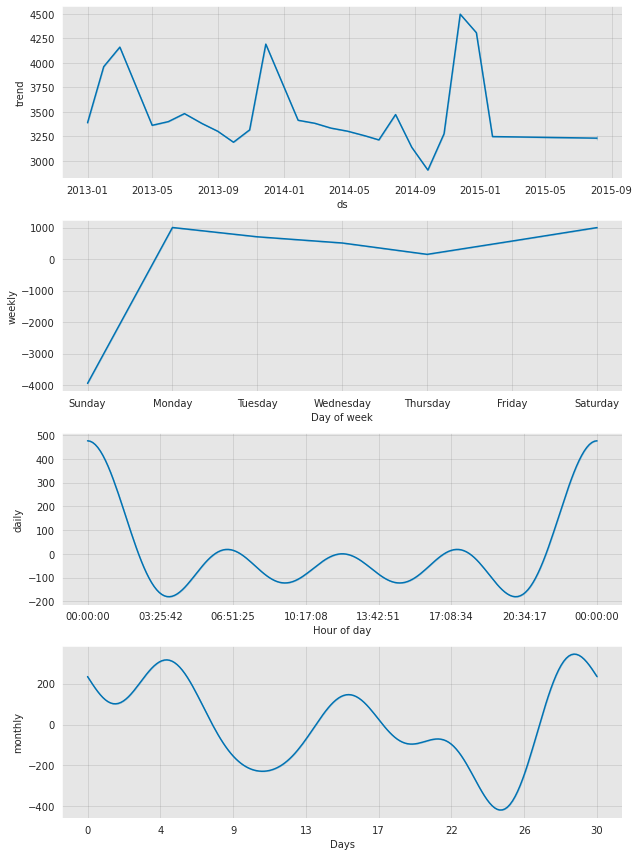

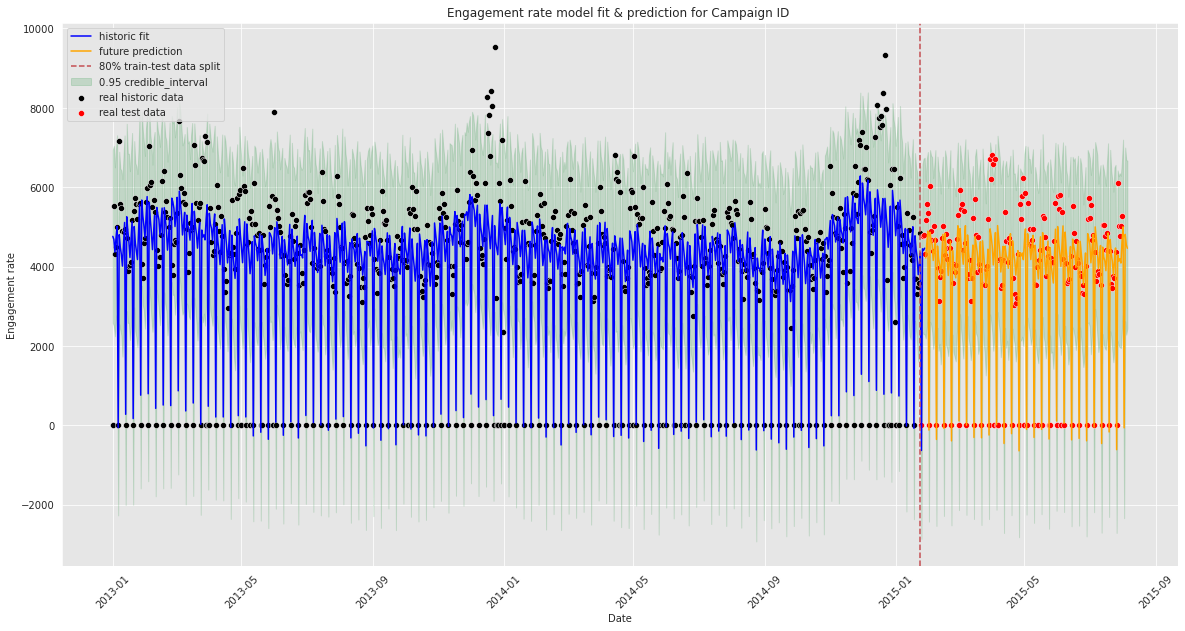

In [21]:
plot_prophet(tsdf, changepoint_prior_scale = 10,  periods = 5) 
#              seasonality_prior_scale = 0.05

In [ ]:
model = Prophet(changepoint_prior_scale=0.3, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False).fit(tsdf)
future = model.make_future_dataframe(periods=10)
forecast = model.predict(future)

In [ ]:
df_cv = cross_validation(model, initial='10 days', period = '2 days', horizon = '5 days',) 
#                          parallel="processes")
df_cv

In [ ]:
plot_prophet(tsdf2, changepoint_prior_scale = 10, periods = 1)

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.0005, 0.001, 0.005, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.005, 0.01, 0.05, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(tsdf2)  # Fit model with given params
    df_cv = cross_validation(m, horizon= '5 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

In [ ]:
split = 0.8
# el = int(len(tsdf.ds)*split)
threshold_date_train = tsdf.ds[ int(len(tsdf.ds)*split) ]
threshold_date_forecast = forecast.ds[ int(len(forecast.ds)*split) ]

forecast_train = forecast[ threshold_date_forecast >= forecast.ds ]
forecast_test = forecast[ threshold_date_forecast < forecast.ds ]
df_train = tsdf[ threshold_date_train >= tsdf.ds ]
df_test = tsdf[ threshold_date_train < tsdf.ds ]

In [ ]:
plot_prophet(tsdf2, changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.005, periods = 5)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
# plt.figure()
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

ax.fill_between( x=forecast['ds'], y1=forecast['yhat_lower'], y2=forecast['yhat_upper'],
    color=sns_c[2], alpha=0.25, label=r'0.95 credible_interval')

sns.scatterplot(x='ds', y='y', label='real historic data', data=df_train, ax=ax, color='black')
sns.lineplot(x='ds', y='y', label='model fit', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='historic fit', data=forecast_train, ax=ax, color = 'blue')
sns.lineplot(x='ds', y='yhat', label='future prediction', data=forecast_test, ax=ax, color = 'orange')
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='80% train-test data split')
ax.legend(loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('Engagement rate')
ax.tick_params(axis='x', rotation=45)
ax.set(title='Engagement rate model fit & prediction for Campaign ID ')